## Setup imports

In [1]:
import tensorflow as tf
import os
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.utils import shuffle
import random
from tensorflow.compiler.tf2xla.python import xla


In [2]:
rand_seed = 42
tf.random.set_seed(rand_seed)
weights_base_path = ""
images_base_path = ""

## Load the dataset and visualize the data

We use the `keras.datasets.mnist.load_data()` utility to directly pull the MNIST dataset
in the form of `NumPy` arrays. We then arrange it in the form of the train and test
splits.

Following loading the dataset, we select 4 random samples from within the training set
and visualize them using `matplotlib.pyplot`.

11490434/11490434 [==============================] - 0s 0us/step
4 Random Training samples and labels


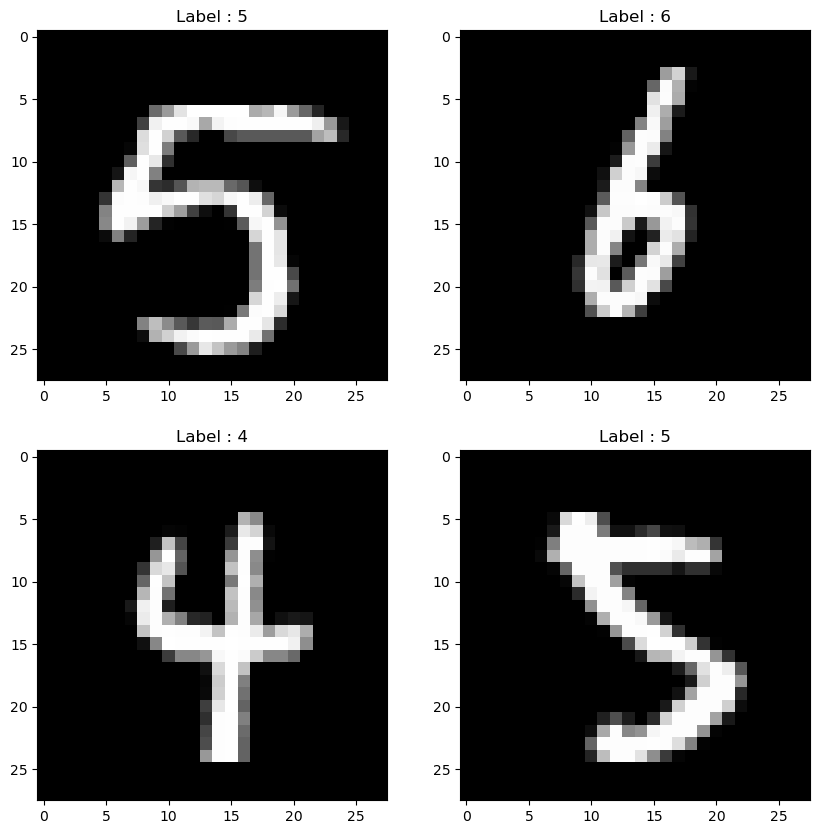

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train, y_train = shuffle(x_train, y_train, random_state=rand_seed)
x_test, y_test = shuffle(x_test, y_test, random_state=rand_seed)

print("4 Random Training samples and labels")
idx1, idx2, idx3, idx4 = random.sample(range(0, x_train.shape[0]), 4)

img1 = (x_train[idx1], y_train[idx1])
img2 = (x_train[idx2], y_train[idx2])
img3 = (x_train[idx3], y_train[idx3])
img4 = (x_train[idx4], y_train[idx4])

imgs = [img1, img2, img3, img4]

plt.figure(figsize=(10, 10))

for idx, item in enumerate(imgs):
    image, label = item[0], item[1]
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label : {label}")
plt.show()

class_names = np.asarray([str(i) for i in range(10)])

true_labels = class_names[y_test]


## Performance metrics and visualization

In [4]:
def plot_loss_curve(history, title, path_to_save=None):
    plt.plot(history.history["FinalLoss"], label="Training loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    if path_to_save:
        plt.savefig(path_to_save)


def load_eval_best_model(model, weights_path, test_images, true_labels, class_names, model_name):
    model.load_weights(weights_path)
    preds = model.predict(tf.convert_to_tensor(test_images))
    preds = preds.reshape((preds.shape[0], preds.shape[1]))
    pred_labels = class_names[np.argmax(preds, axis=1)]
   
    cm = confusion_matrix(true_labels, preds)

    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)

    disp.plot(ax=ax, xticks_rotation='vertical', colorbar=False)
    plt.title("Confusion matrix of the " +
              model_name + " model on MNIST test set")
    plt.show()

    acc = accuracy_score(true_labels, preds)
    print(f"Test error rate: {1 - acc:.4f}")
    print(classification_report(true_labels, preds))


## Define `FFDense` custom layer


In [5]:

class FFDense(keras.layers.Layer):
    """
    A custom ForwardForward-enabled Dense layer. It has an implementation of the
    Forward-Forward network internally for use.
    This layer must be used in conjunction with the `FFNetwork` model.
    """

    def __init__(
        self,
        units,
        optimizer,
        loss_metric,
        num_epochs=50,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dense = keras.layers.Dense(
            units=units,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs


    def call(self, x):
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.dense(x_dir)
        return self.relu(res)


    def forward_forward(self, x_pos, x_neg):

            for i in range(self.num_epochs):
                with tf.GradientTape() as tape:
                    g_pos = tf.math.reduce_mean(tf.math.pow(self.call(x_pos), 2), 1)
                    g_neg = tf.math.reduce_mean(tf.math.pow(self.call(x_neg), 2), 1)

                    margin_loss = tf.maximum(0., self.threshold - g_pos + g_neg)
                    mean_margin_loss = tf.reduce_mean(margin_loss)

                    self.loss_metric.update_state([mean_margin_loss])
                gradients = tape.gradient(mean_margin_loss, self.dense.trainable_weights)
                self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))

            return (
                tf.stop_gradient(self.call(x_pos)),
                tf.stop_gradient(self.call(x_neg)),
                self.loss_metric.result(),
            )


## Define the `FFNetwork` Custom Model

In [6]:

class FFNetwork(keras.Model):
    """
    A `keras.Model` that supports a `FFDense` network creation. This model
    can work for any kind of classification task. It has an internal
    implementation with some details specific to the MNIST dataset which can be
    changed as per the use-case.
    """

    def __init__(
        self,
        dims,
        layer_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.03),
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.layer_optimizer = layer_optimizer
        self.loss_var = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.loss_count = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.layer_list = [keras.Input(shape=(dims[0],))]
        for d in range(2):
            self.layer_list += [
                FFDense(
                    500,
                    optimizer=self.layer_optimizer,
                    loss_metric=keras.metrics.Mean(),
                )
            ]

    @tf.function(reduce_retracing=True)
    def overlay_y_on_x(self, data):
        X_sample, y_sample = data
        max_sample = tf.reduce_max(X_sample, axis=0, keepdims=True)
        max_sample = tf.cast(max_sample, dtype=tf.float64)
        X_zeros = tf.zeros([10], dtype=tf.float64)
        X_update = xla.dynamic_update_slice(X_zeros, max_sample, [y_sample])
        X_sample = xla.dynamic_update_slice(X_sample, X_update, [0])
        return X_sample, y_sample

    @tf.function(reduce_retracing=True)
    def predict_one_sample(self, x):
        goodness_per_label = []
        x = tf.reshape(x, [tf.shape(x)[0] * tf.shape(x)[1]])
        for label in range(10):
            h, label = self.overlay_y_on_x(data=(x, label))
            h = tf.reshape(h, [-1, tf.shape(h)[0]])
            goodness = []
            for layer_idx in range(1, len(self.layer_list)):
                layer = self.layer_list[layer_idx]
                h = layer(h)
                goodness += [tf.math.reduce_mean(tf.math.pow(h, 2), 1)]
            goodness_per_label += [
                tf.expand_dims(tf.reduce_sum(goodness, keepdims=True), 1)
            ]
        goodness_per_label = tf.concat(goodness_per_label, 1)
        return tf.cast(tf.argmax(goodness_per_label, 1), tf.float64)

    def predict(self, data):
        x = data
        preds = list()
        preds = tf.map_fn(fn=self.predict_one_sample, elems=x)
        return np.asarray(preds, dtype=int)

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        # Flatten op
        x = tf.reshape(x, [-1, tf.shape(x)[1] * tf.shape(x)[2]])

        x_pos, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, y))

        random_y = tf.random.shuffle(y)
        x_neg, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, random_y))

        h_pos, h_neg = x_pos, x_neg

        for idx, layer in enumerate(self.layers):
            if isinstance(layer, FFDense):
                print(f"Training layer {idx+1} now : ")
                h_pos, h_neg, loss = layer.forward_forward(h_pos, h_neg)
                self.loss_var.assign_add(loss)
                self.loss_count.assign_add(1.0)
            else:
                print(f"Passing layer {idx+1} now : ")
                x = layer(x)
        mean_res = tf.math.divide(self.loss_var, self.loss_count)
        return {"FinalLoss": mean_res}


## Convert MNIST `NumPy` arrays to `tf.data.Dataset`

We now perform some preliminary processing on the `NumPy` arrays and then convert them
into the `tf.data.Dataset` format which allows for optimized loading.

In [7]:
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)

## Fit the network and visualize results

Having performed all previous set-up, we are now going to run `model.fit()` and run 250
model epochs, which will perform 50*250 epochs on each layer. We get to see the plotted loss
curve as each layer is trained.

In [8]:
model = FFNetwork(dims=[784, 500, 500])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.03),
    loss="mse",
    jit_compile=True,
    metrics=[keras.metrics.Mean()],
)

epochs = 250
history = model.fit(train_dataset, epochs=epochs)

Epoch 1/250
Training layer 1 now : 
Training layer 2 now : 
Training layer 1 now : 
Training layer 2 now : 
1/1 [==============================] - 76s 76s/step - FinalLoss: 1.3154
Epoch 2/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.9474
Epoch 3/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.7436
Epoch 4/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6246
Epoch 5/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5465
Epoch 6/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.4930
Epoch 7/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.4536
Epoch 8/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.4231
Epoch 9/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.3988
Epoch 10/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.3788
Epoch 11/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.362

In [9]:
# save the weights of the model
weights_path = os.path.join(weights_base_path, "exp2")
model.save_weights(weights_path)

## Perform inference and testing

Having trained the model to a large extent, we now see how it performs on the
test set. We calculate the Accuracy Score to understand the results closely.

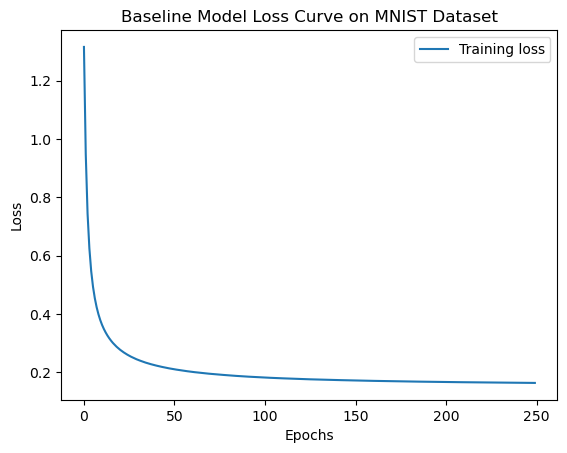

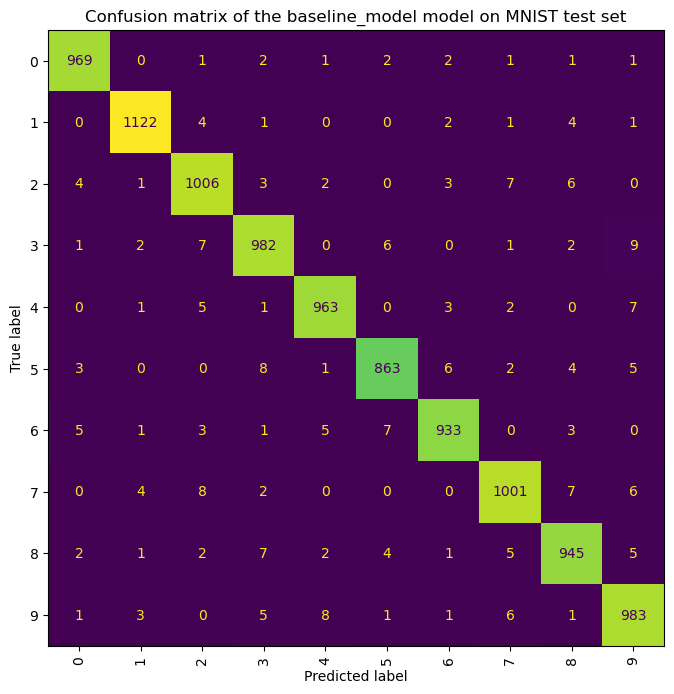

Test error rate: 0.0233
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [10]:

plot_path = os.path.join(images_base_path, "baseline-mnist.png")
plot_loss_curve(history,title="Baseline Model Loss Curve on MNIST Dataset")

model_name = "baseline_model"
load_eval_best_model(model, weights_path, x_test, y_test,class_names, model_name)
